## NESO Metrics ##

Through consulting with the UK National Energy System Operator, we identify two metrics of interest for challenging winters.

1.	The “Worst Winter Day” – which is the most challenging day for ensuring secure electricity supply during the winter, with the lowest wind speeds and coldest temperatures.
2.	The number of high demand-net-wind days – which counts the number of winter days which exceed a defined threshold for demand-net-wind. More challenging days within a winter equates to a more challenging winter for ensuring security of supply.

We test this by:

* Extract ERA5 daily data for temperature and 10m wind speed for the UK, as well as weather dependent electricity demand and wind power generation, from CLEARHEADS.
    * Quantify the worst winter day and high demand-net-wind days for this observed data.
* Using the observations, fit a multiple linear regression (MLR) model for translating daily temperature and 10m wind speed fields into demand-net-wind, with residuals for uncertainty.
* Assemble the model dataframe containing the daily mean values for temperature and 10m wind speed for the UK (over all initialisation years, lead time, and ensemble members).
* Fidelity test the daily data from the model and appropriately bias adjust (if necessary). Consider detrending temperature by pivoting around 2024 climate.
* Apply the observed MLR relationship to the model temperature and wind speed values to get output for daily demand-net-wind.
    * Quantify the worst winter days and high demand-net-wind days for the model data.
* Evaluate the return periods (and associated uncertainty) for both the worst winter days and high demand-net-wind days, using both the modelled and observed data.

In [1]:
# Import local modules
import os
import sys
import glob
import time
import warnings

# Silence warnings
warnings.filterwarnings('ignore')

# Import third-party modules
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

# Specific imports
from tqdm import tqdm
from scipy import stats

In [2]:
# Import local modules
sys.path.append(os.path.join("/home/users/benhutch/unseen_functions/"))
import functions as funcs

# Import the specific functions written for this processing
import functions_regr as funcs_regr

In [3]:
# Create a list of the files to extract
files_to_extract = [
    "NUTS_0_sp_historical.nc",
    "NUTS_0_speed100m_historical.nc",
    "NUTS_0_speed10m_historical.nc",
    "NUTS_0_ssrd_historical.nc",
    "NUTS_0_wp_ofs_sim_0_historical_loc_weighted.nc",
    "NUTS_0_wp_ons_sim_0_historical_loc_weighted.nc",
]

# Create a list with the names
names = [
    "solar_power",
    "100m_wind_speed",
    "10m_wind_speed",
    "solar_irradiance",
    "ofs_cfs",
    "ons_cfs",
]

# set up the country code to extract for
country_code = "UK"

# Set up the directory where the clearhedas data are stored
data_dir = '/home/users/benhutch/CLEARHEADS_EU_Power_Data'

In [4]:
# Set up an empty dataframe to store the data
df_full = pd.DataFrame()

# Loop over the files to extract
for file, name in tqdm(zip(files_to_extract, names)):
    # Load the data
    file_path = os.path.join(data_dir, file)

    # assert that the file exists
    assert os.path.exists(file_path), f"File {file_path} does not exist"

    # Load the data
    ds = xr.open_dataset(file_path)

    # # print ds.variables
    # print(ds.variables)

    # assert that NUTS_keys is in the variables
    assert "NUTS_keys" in ds.variables, f"Variable NUTS_keys not found in {file_path}"

    # extract the nuts keys
    nuts_keys = ds["NUTS_keys"].values

    # turn the data into a dataframe
    df = ds.to_dataframe()

    # Pivot the dataframe
    df_pivot = df.reset_index().pivot(
        index="time_in_hours_from_first_jan_1950",
        columns="NUTS",
        values="timeseries_data",
    )

    # set the columns as the nuts keys
    df_pivot.columns = nuts_keys

    # Convert 'time_in_hours_from_first_jan_1950' column to datetime
    df_pivot.index = pd.to_datetime(df_pivot.index, unit="h", origin="1950-01-01")

    # constrain to the "UK" column
    df_pivot = df_pivot[country_code]

    # if this is the first iteration, set the index
    if df_full.empty:
        df_full = df_pivot.to_frame(name=name)
    else:
        df_full[name] = df_pivot

0it [00:00, ?it/s]

6it [00:20,  3.35s/it]


In [5]:
# import the temperature data with different levels of detrending
file_path = os.path.join(data_dir, "NUTS_0_t2m_detrended_timeseries_historical.nc")

# assert that the file exists
assert os.path.exists(file_path), f"File {file_path} does not exist"

# Load the data
ds = xr.open_dataset(file_path)

# # print ds.variables
# print(ds.variables)

# assert that NUTS_keys is in the variables
assert "NUTS_keys" in ds.variables, f"Variable NUTS_keys not found in {file_path}"

# extract the nuts keys
nuts_keys = ds["NUTS_keys"].values

# trend levle = [1950., 1980., 2010., 2020.,    0.]

# Select the level of detrending
# print the trend_levels variable
print(ds["trend_levels"])

trend_level = 0

# select 0 detrend
# extract the trend levels
trend_levels = ds.trend_levels.values

# Find the index of the trend level
idx = np.where(trend_levels == trend_level)[0][0]

# print the index
print(idx)

# Extract the data
ds = ds.isel(trend=idx)

# turn the data into a dataframe
df = ds.to_dataframe()

# Pivot the dataframe
df_pivot = df.reset_index().pivot(
    index="time_in_hours_from_first_jan_1950",
    columns="NUTS",
    values="detrended_data",
)

# set the columns as the nuts keys
df_pivot.columns = nuts_keys

# Convert 'time_in_hours_from_first_jan_1950' column to datetime
df_pivot.index = pd.to_datetime(df_pivot.index, unit="h", origin="1950-01-01")

# constrain to the "UK" column
df_pivot = df_pivot[country_code]

# if this is the first iteration, set the index
if df_full.empty:
    df_full = df_pivot.to_frame(name="t2m_no_detrend")
else:
    df_full["t2m_no_detrend"] = df_pivot

<xarray.DataArray 'trend_levels' (trend: 5)> Size: 20B
[5 values with dtype=float32]
Dimensions without coordinates: trend
4


In [6]:
# import the temperature data with different levels of detrending
file_path = os.path.join(data_dir, "NUTS_0_t2m_detrended_timeseries_historical.nc")

# assert that the file exists
assert os.path.exists(file_path), f"File {file_path} does not exist"

# Load the data
ds = xr.open_dataset(file_path)

# # print ds.variables
# print(ds.variables)

# assert that NUTS_keys is in the variables
assert "NUTS_keys" in ds.variables, f"Variable NUTS_keys not found in {file_path}"

# extract the nuts keys
nuts_keys = ds["NUTS_keys"].values

# trend levle = [1950., 1980., 2010., 2020.,    0.]

# Select the level of detrending
# print the trend_levels variable
print(ds["trend_levels"])

trend_level = 2020

# select 0 detrend
# extract the trend levels
trend_levels = ds.trend_levels.values

# Find the index of the trend level
idx = np.where(trend_levels == trend_level)[0][0]

# print the index
print(idx)

# Extract the data
ds = ds.isel(trend=idx)

# turn the data into a dataframe
df = ds.to_dataframe()

# Pivot the dataframe
df_pivot = df.reset_index().pivot(
    index="time_in_hours_from_first_jan_1950",
    columns="NUTS",
    values="detrended_data",
)

# set the columns as the nuts keys
df_pivot.columns = nuts_keys

# Convert 'time_in_hours_from_first_jan_1950' column to datetime
df_pivot.index = pd.to_datetime(df_pivot.index, unit="h", origin="1950-01-01")

# constrain to the "UK" column
df_pivot = df_pivot[country_code]

# if this is the first iteration, set the index
if df_full.empty:
    df_full = df_pivot.to_frame(name="t2m_2020_detrend")
else:
    df_full["t2m_2020_detrend"] = df_pivot

<xarray.DataArray 'trend_levels' (trend: 5)> Size: 20B
[5 values with dtype=float32]
Dimensions without coordinates: trend
3


In [7]:
# collapse df_full into daily means
df_full_daily = df_full.resample("D").mean()

In [8]:
df_full_daily.head()

,solar_power,100m_wind_speed,10m_wind_speed,solar_irradiance,ofs_cfs,ons_cfs,t2m_no_detrend,t2m_2020_detrend
time_in_hours_from_first_jan_1950,,,,,,,,
1950-01-01,0.017917,8.046321,5.313241,18.246765,0.375553,0.378995,5.568366,7.035546
1950-01-02,0.009749,8.309860,5.536100,10.066186,0.755816,0.260311,7.458939,8.926063
1950-01-03,0.006689,5.999976,3.996584,6.909895,0.383306,0.247291,6.999079,8.466145
1950-01-04,0.014198,7.579509,4.991658,14.658528,0.503725,0.366872,7.507976,8.974984
1950-01-05,0.009825,9.282607,6.286204,10.173406,0.768395,0.415419,6.869317,8.336267


In [9]:
# path to demand data
path="/home/users/benhutch/energy-sotcr-2023/data/ERA5_UK_1940_2024_daily_SP_WP_demand_wind.csv"

# impoet this df
df_demand = pd.read_csv(path)

# subset to United_Kingdom_demand and United_Kingdom_wd_demand
df_demand_subset = df_demand[["date", "United_Kingdom_demand", "United_Kingdom_wd_demand"]]

# set date as datetime
df_demand_subset["date"] = pd.to_datetime(df_demand_subset["date"])

# set date as index
df_demand_subset.set_index("date", inplace=True)

In [10]:
#get the min and max date of df_full_daily
min_date = df_full_daily.index.min()
max_date = df_full_daily.index.max()

# subset the demand data to the same date range
df_demand_subset = df_demand_subset.loc[min_date:max_date]

# merge the two dataframes
df_full_daily = pd.concat([df_full_daily, df_demand_subset], axis=1)

In [11]:
#subset to ONDJFM mean
df_full_daily_ONDJFM = df_full_daily[
    (df_full_daily.index.month >= 10) | (df_full_daily.index.month <= 3)
]

In [12]:
# Make some assumptions about the power system
# wind power capacity factors - includes both onshore and offshore?
# also I guess power system is 2021 ish set up?
# although won't have changed significantly since then
# Not sure how accurate these are leached from:
# https://windeurope.org/intelligence-platform/product/wind-energy-in-europe-2023-statistics-and-the-outlook-for-2024-2030/
installed_ofs_2023 = 14.756  # GW
installed_ons_2023 = 14.866  # GW

# set up these but for France
installed_ofs_2023_fr = 0.842  # GW
installed_ons_2023_fr = 21.935  # GW

# calculate the wind power generation
df_full_daily_ONDJFM["wind_gen"] = (
    installed_ofs_2023 * df_full_daily_ONDJFM["ofs_cfs"]
    + installed_ons_2023 * df_full_daily_ONDJFM["ons_cfs"]
)

# calculate the demand net wind
df_full_daily_ONDJFM["demand_net_wind"] = (
    df_full_daily_ONDJFM["United_Kingdom_demand"] - df_full_daily_ONDJFM["wind_gen"]
)

# calculate the weather dependent demand
df_full_daily_ONDJFM["wd_demand_net_wind"] = (
    df_full_daily_ONDJFM["United_Kingdom_wd_demand"] - df_full_daily_ONDJFM["wind_gen"]
)

In [13]:
df_full_daily_ONDJFM.tail()

,solar_power,100m_wind_speed,10m_wind_speed,solar_irradiance,ofs_cfs,ons_cfs,t2m_no_detrend,t2m_2020_detrend,United_Kingdom_demand,United_Kingdom_wd_demand,wind_gen,demand_net_wind,wd_demand_net_wind
2020-12-27,0.023757,8.940444,5.979577,24.189680,0.615395,0.446767,3.649454,3.628710,39.387627,44.078443,15.722401,23.665226,28.356042
2020-12-28,0.018903,5.019287,3.424141,19.100378,0.200217,0.086603,1.774313,1.753511,45.024194,45.832464,4.241845,40.782349,41.590619
2020-12-29,0.020817,7.124440,4.698165,21.119453,0.311446,0.210541,2.592501,2.571643,45.236083,45.236083,7.725595,37.510488,37.510488
2020-12-30,0.023254,5.399757,3.439529,23.473879,0.334843,0.130754,1.594081,1.573165,46.053290,46.053290,6.884724,39.168566,39.168566
2020-12-31,0.023311,6.773319,4.563665,23.496550,0.205502,0.190531,1.811103,1.790130,46.040684,46.040684,5.864829,40.175855,40.175855


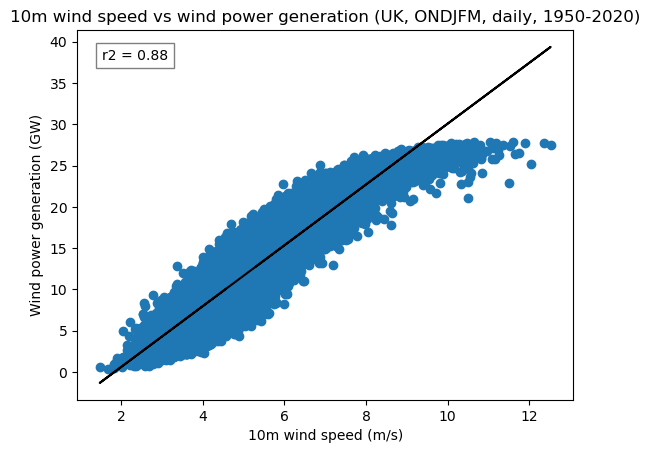

In [14]:
# Plot scatter of 10m wind speed and wind power generation
funcs_regr.plot_scatter_with_fit(
    df=df_full_daily_ONDJFM,
    x_col="10m_wind_speed",
    y_col="wind_gen",
    title="10m wind speed vs wind power generation (UK, ONDJFM, daily, 1950-2020)",
    xlabel="10m wind speed (m/s)",
    ylabel="Wind power generation (GW)",
)

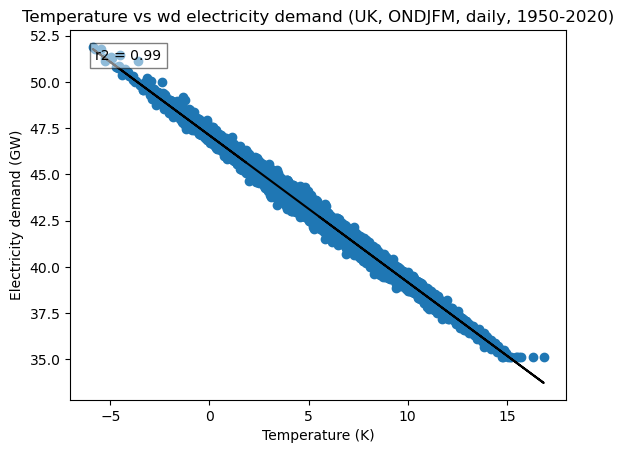

In [15]:
# Same but for temperature and electricity demand
funcs_regr.plot_scatter_with_fit(
    df=df_full_daily_ONDJFM,
    x_col="t2m_no_detrend",
    y_col="United_Kingdom_wd_demand",
    title="Temperature vs wd electricity demand (UK, ONDJFM, daily, 1950-2020)",
    xlabel="Temperature (K)",
    ylabel="Electricity demand (GW)",
)

In [16]:
import importlib

importlib.reload(funcs_regr)

<module 'functions_regr' from '/home/users/benhutch/unseen_functions/functions_regr.py'>

R-squared: 0.90
RMSE: 2.43


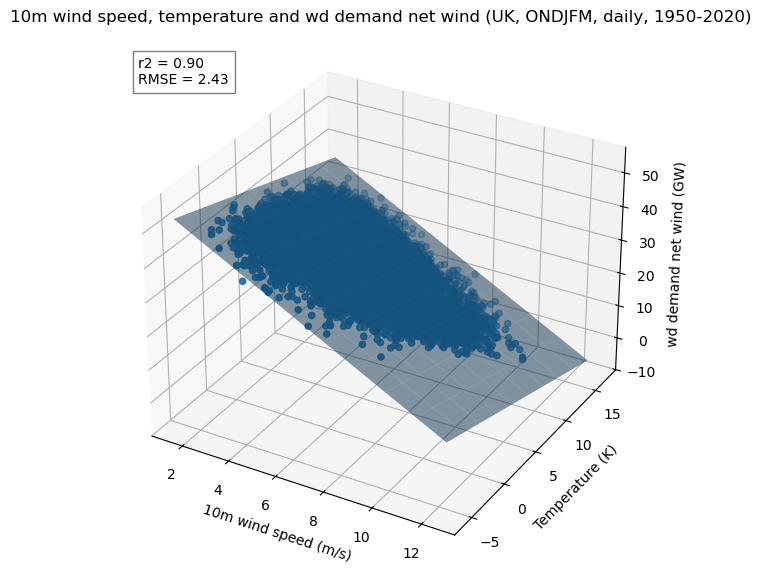

In [17]:
# 3D scatter plot of 10m wind speed, temperature and wd demand net wind
funcs_regr.plot_3d_scatter(
    df=df_full_daily_ONDJFM,
    x_col="10m_wind_speed",
    y_col="t2m_no_detrend",
    z_col="wd_demand_net_wind",
    title="10m wind speed, temperature and wd demand net wind (UK, ONDJFM, daily, 1950-2020)",
    xlabel="10m wind speed (m/s)",
    ylabel="Temperature (K)",
    zlabel="wd demand net wind (GW)",
)

100%|██████████| 10/10 [00:00<00:00, 12.38it/s]


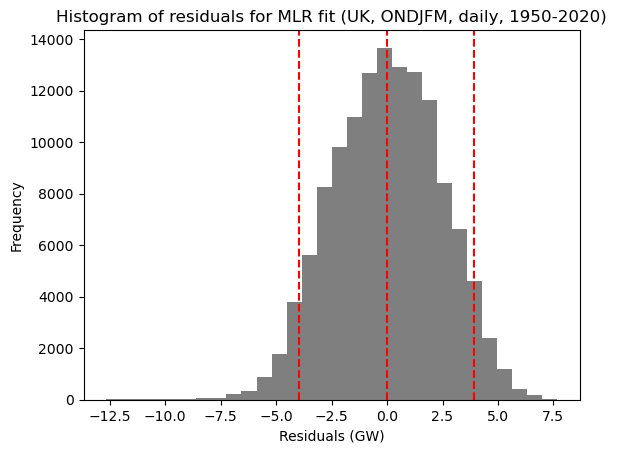

Mean residual spread: 2.43
5th percentile residual spread: 2.40
95th percentile residual spread: 2.45
Mean r2: 0.90
5th percentile r2: 0.90
95th percentile r2: 0.90
Mean RMSE: 2.43
5th percentile RMSE: 2.40
95th percentile RMSE: 2.45


In [18]:
# Plot the histograms of the block bootstrapped residuals for the MLR fit
# Default block length = 10 day chunks (independent samples?)
funcs_regr.plot_residual_hist_mlr(
    df=df_full_daily_ONDJFM,
    X1_col="10m_wind_speed",
    X2_col="t2m_no_detrend",
    Y_col="wd_demand_net_wind",
    title="Histogram of residuals for MLR fit (UK, ONDJFM, daily, 1950-2020)",
    xlabel="Residuals (GW)",
    ylabel="Frequency",
    nboot=10,
)

In [19]:
importlib.reload(funcs_regr)

<module 'functions_regr' from '/home/users/benhutch/unseen_functions/functions_regr.py'>

In [20]:
df_full_daily_ONDJFM.tail()

,solar_power,100m_wind_speed,10m_wind_speed,solar_irradiance,ofs_cfs,ons_cfs,t2m_no_detrend,t2m_2020_detrend,United_Kingdom_demand,United_Kingdom_wd_demand,wind_gen,demand_net_wind,wd_demand_net_wind
2020-12-27,0.023757,8.940444,5.979577,24.189680,0.615395,0.446767,3.649454,3.628710,39.387627,44.078443,15.722401,23.665226,28.356042
2020-12-28,0.018903,5.019287,3.424141,19.100378,0.200217,0.086603,1.774313,1.753511,45.024194,45.832464,4.241845,40.782349,41.590619
2020-12-29,0.020817,7.124440,4.698165,21.119453,0.311446,0.210541,2.592501,2.571643,45.236083,45.236083,7.725595,37.510488,37.510488
2020-12-30,0.023254,5.399757,3.439529,23.473879,0.334843,0.130754,1.594081,1.573165,46.053290,46.053290,6.884724,39.168566,39.168566
2020-12-31,0.023311,6.773319,4.563665,23.496550,0.205502,0.190531,1.811103,1.790130,46.040684,46.040684,5.864829,40.175855,40.175855


Sampling uncertainty in the MLR fit via stochastic trials.
And sample uncertainty in the time series via block bootstrapping.


  0%|          | 0/10 [00:00<?, ?it/s]

(12940, 2)


100%|██████████| 10/10 [00:00<00:00, 12.34it/s]


Shape of Y_pred_first: (12940,)
Shape of stoch_mean: (12940, 1000)
Trials mean head:                   0          1          2          3          4          5    \
1950-01-01  28.596473  34.388622  31.493647  27.118648  29.341505  30.142510   
1950-01-02  30.765023  26.994278  29.081166  29.770396  23.731015  26.460800   
1950-01-03  31.856797  32.909943  32.734148  32.065033  30.638020  30.671786   
1950-01-04  26.204062  28.969833  32.508854  30.465466  32.169163  32.357230   
1950-01-05  26.194507  22.767401  23.306747  27.560539  27.697327  22.322816   

                  6          7          8          9    ...        990  \
1950-01-01  31.374331  33.217449  33.407838  30.470019  ...  27.202247   
1950-01-02  23.106747  24.715379  30.832602  25.066183  ...  30.466614   
1950-01-03  33.982809  29.996301  35.648323  32.526064  ...  34.712731   
1950-01-04  28.263400  30.533908  29.776895  31.110533  ...  30.337591   
1950-01-05  23.535451  21.135780  27.923045  25.110429  ...  23.

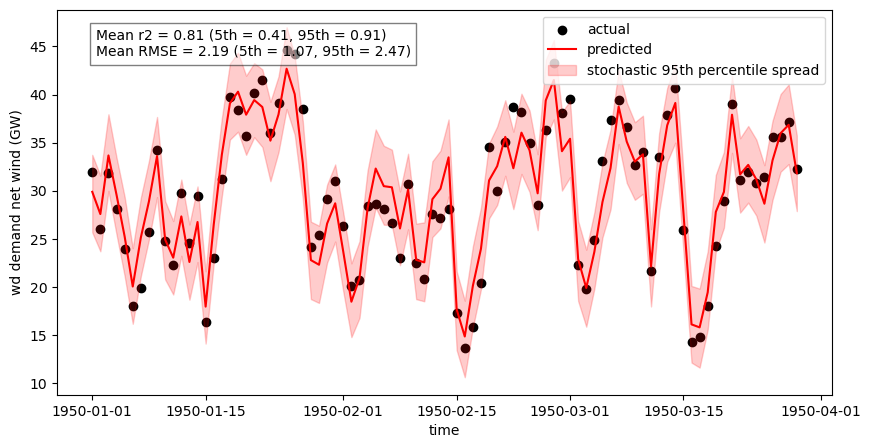

In [21]:
# Plot the stochastic fit
funcs_regr.plot_stochastic_fit(
    df=df_full_daily_ONDJFM,
    X1_col="10m_wind_speed",
    X2_col="t2m_no_detrend",
    Y_col="wd_demand_net_wind",
    title="stochastic fit (UK, ONDJFM, daily, 1950-2020)",
    xlabel="time",
    ylabel="wd demand net wind (GW)",
    sample_uncertainty=True, # include uncertainty in the fit and samples
    nboot=10,
)

Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb


Text(0.5, 0, 'Date (MM-DD), noleap')

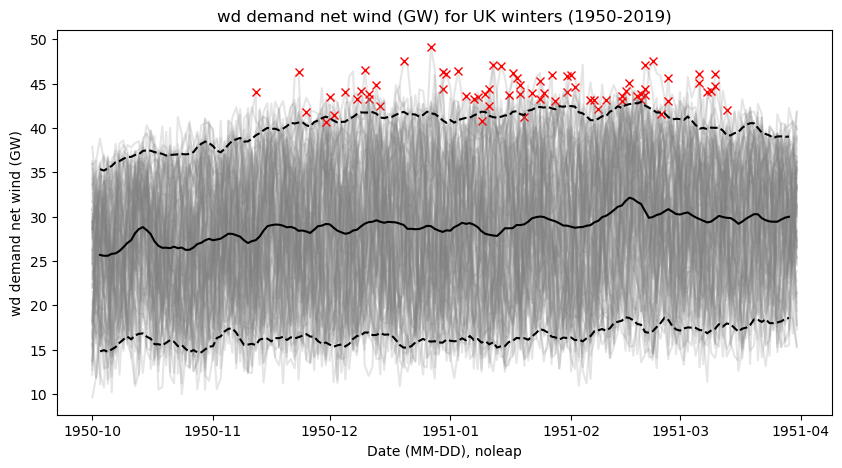

In [22]:
# Set up the full winter years
winter_years = np.arange(1950, 2019 + 1)

# set up a figure
fig, ax = plt.subplots(figsize=(10, 5))

# Set up the x-axis
index_date = pd.date_range(start="1950-10-01", end="1951-03-31", freq="D")

# set up an array of zeros to store the data
data = np.zeros([len(winter_years), len(index_date)])

# Set up an array to store the max values
max_values = np.zeros(len(winter_years))

# set up an array to store the dates of the max values
dates_max_values = []

# loop over the winter years
for year in winter_years:
    # # print the year
    # print(year)
    # Set up the first and last day of the winter
    winter_start = pd.Timestamp(f"{year}-10-01")
    winter_end = pd.Timestamp(f"{year+1}-03-31")

    # subset the data
    df = df_full_daily_ONDJFM.loc[winter_start:winter_end]

    # find the highest value of the wd_demand_net_wind
    max_wd_demand_net_wind = df["wd_demand_net_wind"].max()

    # find the date
    date_max_wd_demand_net_wind = df["wd_demand_net_wind"].idxmax()

    # extract the mm and dd of the date
    mm = date_max_wd_demand_net_wind.month
    dd = date_max_wd_demand_net_wind.day

    # if the month is 10, 11 or 12, set the year to the current year
    if mm in [10, 11, 12]:
        yyyy = 1950
    else:
        yyyy = 1951

    # set the date
    date_max_wd_demand_net_wind = pd.Timestamp(f"{yyyy}-{mm:02d}-{dd:02d}")

    # # print the shape of df
    # print(df.shape)

    # add the max value to the array
    max_values[year - 1950] = max_wd_demand_net_wind

    # if mm-dd is 02-29, then raise an error
    if f"{mm:02d}-{dd:02d}" == "02-29":
        raise ValueError("29th Feb found")
    
    # add the value to the array
    dates_max_values.append(date_max_wd_demand_net_wind)

    # # print all of the feb dates
    # print(df.index[df.index.month == 2])

    # if df includes 29th feb, then drop this row
    if f"{year + 1}-02-29" in df.index:
        print("Dropping 29th Feb")
        df = df.drop(pd.Timestamp(f"{year + 1}-02-29"))

    # # print the shapes of the data
    # print(df.shape)
    # print(df["wd_demand_net_wind"].shape)
    # print(index_date.shape)

    # plot the data
    ax.plot(index_date, df["wd_demand_net_wind"], color="grey", alpha=0.2)

    # plot the max value as a red x
    ax.plot(date_max_wd_demand_net_wind, max_wd_demand_net_wind, "rx")

    # set the data
    data[year - 1950, :] = df["wd_demand_net_wind"].values

# Calculate the mean for each date
mean_data = np.mean(data, axis=0)

# Calculate the 5-95% confidence intervals
low_ci = np.percentile(data, 5, axis=0)
high_ci = np.percentile(data, 95, axis=0)

# add these to a dataframe with the index_date as the index
df_mean = pd.DataFrame(
    {
        "mean": mean_data,
        "low_ci": low_ci,
        "high_ci": high_ci,
    },
    index=index_date,
)

# add a new column for the 5-day centred rolling mean
df_mean["mean_5day"] = df_mean["mean"].rolling(5, center=True).mean()
df_mean["low_ci_5day"] = df_mean["low_ci"].rolling(5, center=True).mean()
df_mean["high_ci_5day"] = df_mean["high_ci"].rolling(5, center=True).mean()

# # plot the mean data as a red line
# ax.plot(index_date, mean_data, "r")

# # plot the 5-95% confidence intervals
# ax.plot(index_date, low_ci, "r--")
# ax.plot(index_date, high_ci, "r--")

# plot the 5-day centred rolling mean
ax.plot(index_date, df_mean["mean_5day"], "k")

# plot the 5-95% confidence intervals for the 5-day centred rolling mean
ax.plot(index_date, df_mean["low_ci_5day"], color="k", linestyle="--")
ax.plot(index_date, df_mean["high_ci_5day"], color="k", linestyle="--")

# ylabel
ax.set_ylabel("wd demand net wind (GW)")

# title
ax.set_title("wd demand net wind (GW) for UK winters (1950-2019)")

# set the xlabel
ax.set_xlabel("Date (MM-DD), noleap")

In [23]:
# Set up a dataframe
df_max_values = pd.DataFrame(
    {
        "dates_max_values": dates_max_values,
        "max_values": max_values,
    },
)

mean: -5.979546514285714e+17, date: 1951-01-20
median: -5.97888e+17, date: 1951-01-21
low_ci: -6.02073216e+17, date: 1950-12-03
high_ci: -5.9386608e+17, date: 1951-03-08
[-6.06e+17, -6.04e+17, -6.02e+17, -6e+17, -5.98e+17, -5.96e+17, -5.94e+17, -5.92e+17]


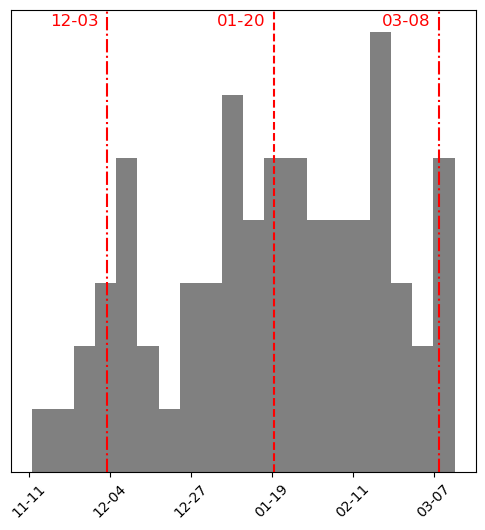

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Convert numpy.datetime64 to datetime.date
# dates = df_max_values["dates_max_values"].dt.date


# Plot the boxplot
fig, ax = plt.subplots(figsize=(6, 6))
df_max_values["dates_max_values"].astype(np.int64).plot.hist(ax=ax, bins=20, color="grey")
# df_max_values["dates_max_values"].astype(np.int64).plot.kde(ax=ax, secondary_y=True)

# calculate the median
median = df_max_values["dates_max_values"].astype(np.int64).median()

# calculate the mean
mean = df_max_values["dates_max_values"].astype(np.int64).mean()

# calculate the 05 and 95 percentiles
low_ci = np.percentile(df_max_values["dates_max_values"].astype(np.int64), 8)
high_ci = np.percentile(df_max_values["dates_max_values"].astype(np.int64), 95)

# plot the mean as a vertical red line
ax.axvline(mean, color="r", linestyle="--", label=f"Mean: {mean}")

# plot the 05 as a dotdash line
ax.axvline(low_ci, color="r", linestyle="-.", label=f"8%: {low_ci}")
ax.axvline(high_ci, color="r", linestyle="-.", label=f"95%: {high_ci}")

# pritn the mean and the date
print(f"mean: {mean}, date: {pd.to_datetime(int(mean)).date()}")
print(f"median: {median}, date: {pd.to_datetime(int(median)).date()}")
print(f"low_ci: {low_ci}, date: {pd.to_datetime(int(low_ci)).date()}")
print(f"high_ci: {high_ci}, date: {pd.to_datetime(int(high_ci)).date()}")

labels = ax.get_xticks().tolist()
# print the labels
print(labels)

# strip to only be MM-DD
labels = pd.to_datetime(labels)
# # print the labels
# print


# # convert to MM-DD
labels = [date.strftime("%m-%d") for date in labels]
ax.set_xticklabels(labels, rotation=45)

# set up date values 

# # set the xticks as Oct, Nov, Dec, Jan, Feb, Mar
# Create a list of dates
# dates = [
#     pd.Timestamp("1950-10-01"),
#     pd.Timestamp("1950-11-01"),
#     pd.Timestamp("1950-12-01"),
#     pd.Timestamp("1951-01-01"),
#     pd.Timestamp("1951-02-01"),
#     pd.Timestamp("1951-03-01"),
# ]

# # Convert dates to ordinal integers
# ordinal_dates = [date.toordinal() for date in dates]

# # Set the x-ticks to the ordinal integers
# ax.set_xticks(ordinal_dates)

# # Format the x-tick labels to display as dates
# ax.set_xticklabels([date.strftime("%m-%d") for date in dates], rotation=45)


# Convert ordinal values back to datetime.date for y-axis labels
# yticks = ax.get_yticks()
# yticks_dates = [pd.to_datetime(int(ytick)).date() for ytick in yticks]

# # Set y-axis labels
# ax.set_yticklabels(yticks_dates)

mean_date = pd.to_datetime(int(mean)).date().strftime("%m-%d")
low_ci_date = pd.to_datetime(int(low_ci)).date().strftime("%m-%d")
high_ci_date = pd.to_datetime(int(high_ci)).date().strftime("%m-%d")

# quantify what 1 day is equivalent to in terms of the x-axis
oneday_shift = (ax.get_xticks()[1] - ax.get_xticks()[0])

# plot the mean date as MM-DD next to the mean line
ax.text(mean - 0.4*(oneday_shift), 7.1, mean_date, ha="center", fontsize=12, color="red")

# plot the 05 date as MM-DD next to the 05 line
ax.text(low_ci - 0.4*(oneday_shift), 7.1, low_ci_date, ha="center", fontsize=12, color="red")

# plot the 95 date as MM-DD next to the 95 line
ax.text(high_ci - 0.4*(oneday_shift), 7.1, high_ci_date, ha="center", fontsize=12, color="red")

# xlabels = ["Oct", "Nov", "Dec", "Jan", "Feb", "Mar", "Apr"]
# ax.set_xticks([
#     pd.Timestamp("1950-10-01"),
#     pd.Timestamp("1950-11-01"),
#     pd.Timestamp("1950-12-01"),
#     pd.Timestamp("1951-01-01"),
#     pd.Timestamp("1951-02-01"),
#     pd.Timestamp("1951-03-01"),
#     pd.Timestamp("1951-04-01"),
# ])

# # Set the xticklabels
# ax.set_xticklabels(xlabels)


# remove the yticks
ax.set_yticks([])

# remove the frequency label
ax.set_ylabel("")

# plt.xlabel('Dates')
# plt.ylabel('Ordinal Values')
# plt.title('Worst wd demand-net-wind dates distribution (UK, ONDJFM, 1950-2019)')
# plt.show()

# set the time
now = pd.Timestamp.now().strftime("%Y-%m-%d_%H-%M-%S")

# set the path to the plot
path = f"/home/users/benhutch/unseen_multi_year/plots/worst_wd_demand_net_wind_dates_hist_{now}.png"

# save the plot
plt.savefig(path, dpi=600, bbox_inches="tight")

In [25]:
data.shape

(70, 182)

In [26]:
# Quantify the 80% tile value for wd demand-net-wind for all winter days
all_winters_95 = np.percentile(data.flatten(), 80)

Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb


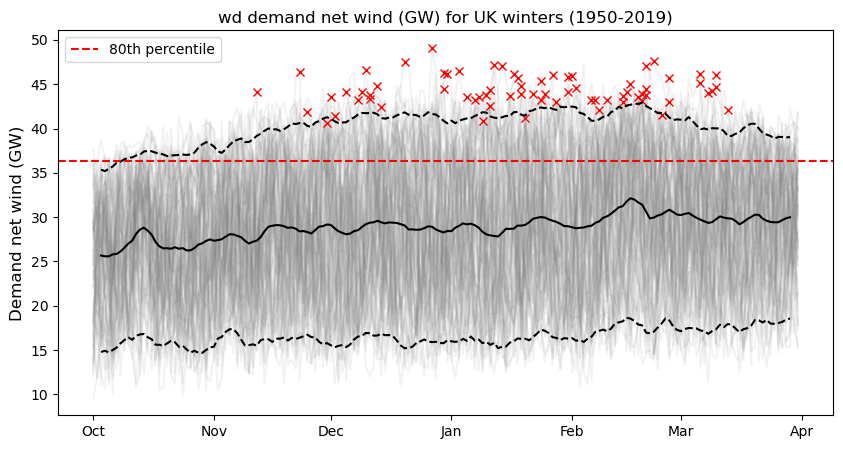

In [27]:
# Set up the full winter years
winter_years = np.arange(1950, 2019 + 1)

# set up a figure
fig, ax = plt.subplots(figsize=(10, 5))

# Set up the x-axis
index_date = pd.date_range(start="1950-10-01", end="1951-03-31", freq="D")

# set up an array of zeros to store the data
data = np.zeros([len(winter_years), len(index_date)])

# Set up an array to store the max values
max_values = np.zeros(len(winter_years))

# set up an array to store the dates of the max values
dates_max_values = []

# loop over the winter years
for year in winter_years:
    # # print the year
    # print(year)
    # Set up the first and last day of the winter
    winter_start = pd.Timestamp(f"{year}-10-01")
    winter_end = pd.Timestamp(f"{year+1}-03-31")

    # subset the data
    df = df_full_daily_ONDJFM.loc[winter_start:winter_end]

    # find the highest value of the wd_demand_net_wind
    max_wd_demand_net_wind = df["wd_demand_net_wind"].max()

    # find the date
    date_max_wd_demand_net_wind = df["wd_demand_net_wind"].idxmax()

    # extract the mm and dd of the date
    mm = date_max_wd_demand_net_wind.month
    dd = date_max_wd_demand_net_wind.day

    # if the month is 10, 11 or 12, set the year to the current year
    if mm in [10, 11, 12]:
        yyyy = 1950
    else:
        yyyy = 1951

    # set the date
    date_max_wd_demand_net_wind = pd.Timestamp(f"{yyyy}-{mm:02d}-{dd:02d}")

    # # print the shape of df
    # print(df.shape)

    # add the max value to the array
    max_values[year - 1950] = max_wd_demand_net_wind

    # if mm-dd is 02-29, then raise an error
    if f"{mm:02d}-{dd:02d}" == "02-29":
        raise ValueError("29th Feb found")
    
    # add the value to the array
    dates_max_values.append(date_max_wd_demand_net_wind)

    # # print all of the feb dates
    # print(df.index[df.index.month == 2])

    # if df includes 29th feb, then drop this row
    if f"{year + 1}-02-29" in df.index:
        print("Dropping 29th Feb")
        df = df.drop(pd.Timestamp(f"{year + 1}-02-29"))

    # # print the shapes of the data
    # print(df.shape)
    # print(df["wd_demand_net_wind"].shape)
    # print(index_date.shape)

    # plot the data
    ax.plot(index_date, df["wd_demand_net_wind"], color="grey", alpha=0.10)

    # plot the max value as a red x
    ax.plot(date_max_wd_demand_net_wind, max_wd_demand_net_wind, "rx")

    # set the data
    data[year - 1950, :] = df["wd_demand_net_wind"].values

# Calculate the mean for each date
mean_data = np.mean(data, axis=0)

# Calculate the 5-95% confidence intervals
low_ci = np.percentile(data, 5, axis=0)
high_ci = np.percentile(data, 95, axis=0)

# add these to a dataframe with the index_date as the index
df_mean = pd.DataFrame(
    {
        "mean": mean_data,
        "low_ci": low_ci,
        "high_ci": high_ci,
    },
    index=index_date,
)

# add a new column for the 5-day centred rolling mean
df_mean["mean_5day"] = df_mean["mean"].rolling(5, center=True).mean()
df_mean["low_ci_5day"] = df_mean["low_ci"].rolling(5, center=True).mean()
df_mean["high_ci_5day"] = df_mean["high_ci"].rolling(5, center=True).mean()

# # plot the mean data as a red line
# ax.plot(index_date, mean_data, "r")

# # plot the 5-95% confidence intervals
# ax.plot(index_date, low_ci, "r--")
# ax.plot(index_date, high_ci, "r--")

# plot the 5-day centred rolling mean
ax.plot(index_date, df_mean["mean_5day"], "k")

# plot the 5-95% confidence intervals for the 5-day centred rolling mean
ax.plot(index_date, df_mean["low_ci_5day"], color="k", linestyle="--")
ax.plot(index_date, df_mean["high_ci_5day"], color="k", linestyle="--")

# plot the 80% tile value for wd demand-net-wind for all winter days 
# as a vertical line
ax.axhline(all_winters_95, color="r", linestyle="--", label="80th percentile")

# ylabel
ax.set_ylabel("Demand net wind (GW)", fontsize=12)

# title
ax.set_title("wd demand net wind (GW) for UK winters (1950-2019)")

# Set the xlabels as Oct, Nov, Dec, Jan, Feb, Mar, Apr
xlabels = ["Oct", "Nov", "Dec", "Jan", "Feb", "Mar", "Apr"]
ax.set_xticks([
    pd.Timestamp("1950-10-01"),
    pd.Timestamp("1950-11-01"),
    pd.Timestamp("1950-12-01"),
    pd.Timestamp("1951-01-01"),
    pd.Timestamp("1951-02-01"),
    pd.Timestamp("1951-03-01"),
    pd.Timestamp("1951-04-01"),
])

# Set the xticklabels
ax.set_xticklabels(xlabels)

# # set the xlabel
# ax.set_xlabel("Date (MM-DD), noleap")

# include a legend in the top left
ax.legend(loc="upper left")

# set up the current time
now = pd.Timestamp.now()

# Set up the path to the fiogurs
path = f"/home/users/benhutch/unseen_multi_year/plots/{now.strftime('%Y%m%d')}_wd_demand_net_wind_UK_winters_1950_2019.png"

# Save the figure high quality bboxinches tight
plt.savefig(path, dpi=600, bbox_inches="tight")

No. days where demand net wind > 80% tile value: 52
Total no. days: 182
Severity index: 197.20082357762692


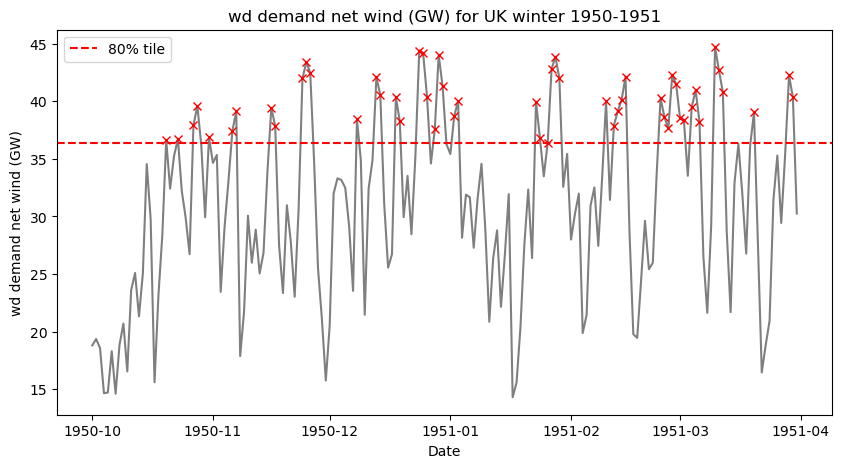

In [28]:
# for the first winter
winter_start = pd.Timestamp(f"{1950}-10-01")
winter_end = pd.Timestamp(f"{1951}-03-31")

# subset the data
df = df_full_daily_ONDJFM.loc[winter_start:winter_end]

# set up the figure
fig, ax = plt.subplots(figsize=(10, 5))

# plot the data
ax.plot(df.index, df["wd_demand_net_wind"], color="k", alpha=0.5)

# plot the 80% tile value for wd demand-net-wind for all winter days
# as a horizontal line
ax.axhline(all_winters_95, color="r", linestyle="--", label=f"80% tile")

# apply a boolean mask to the demand net wind value
# which is true where the demand net wind is greater than the 80% tile value
mask = df["wd_demand_net_wind"] > all_winters_95

# plot the masked values as red crosses
ax.plot(df.index[mask], df["wd_demand_net_wind"][mask], "rx")

# print the proportion of days where the demand net wind is greater than the 80% tile value
print(f"No. days where demand net wind > 80% tile value: {mask.sum()}")
print(f"Total no. days: {len(mask)}")

# define a serverit index
# for each day which exceeds the 80% tile value, set the value to 1 and multiply by
# the difference between the demand net wind and the 80% tile value
severit_index = mask * (df["wd_demand_net_wind"] - all_winters_95)

# print the sum of the severit index
print(f"Severity index: {severit_index.sum()}")

# ylabel
ax.set_ylabel("wd demand net wind (GW)")

# title
ax.set_title("wd demand net wind (GW) for UK winter 1950-1951")

# set the xlabel
ax.set_xlabel("Date")

# cinldue a legend
ax.legend(loc="upper left")

In [29]:
winter_years

array([1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960,
       1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971,
       1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982,
       1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993,
       1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004,
       2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015,
       2016, 2017, 2018, 2019])

Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb


Text(0.5, 0, 'Date')

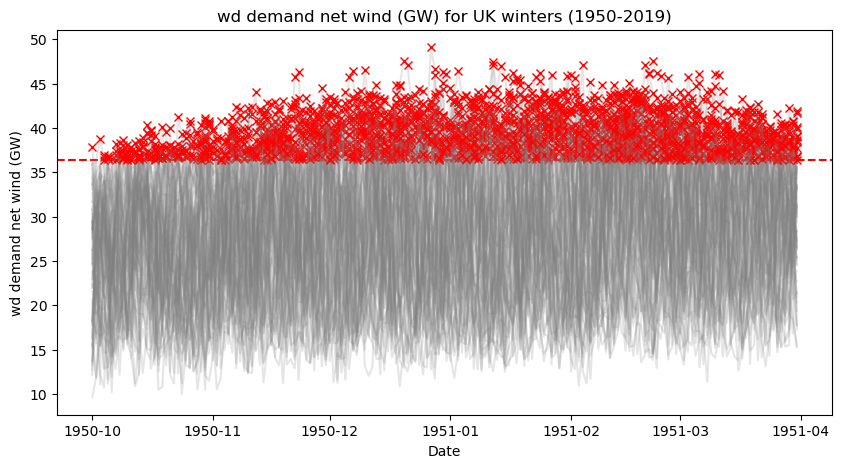

In [30]:
# Now for all of the years
fig, ax = plt.subplots(figsize=(10, 5))

# Set up an array to store the severity index
severity_index = np.zeros(len(winter_years))

# Set up an array to store the no. exceedance days
no_exceedance_days = np.zeros(len(winter_years))

# Set up an empty list for the dates
dates_exceedance_values = []
exceedance_values = []

# plot the 80% tile value for wd demand-net-wind for all winter days
# as a horizontal line
ax.axhline(all_winters_95, color="r", linestyle="--", label=f"80% tile")

# loop over the winter years
for i, year in enumerate(winter_years):
    # Set up the first and last day of the winter
    winter_start = pd.Timestamp(f"{year}-10-01")
    winter_end = pd.Timestamp(f"{year+1}-03-31")

    # subset the data
    df = df_full_daily_ONDJFM.loc[winter_start:winter_end]

    # if df includes 29th feb, then drop this row
    if f"{year + 1}-02-29" in df.index:
        print("Dropping 29th Feb")
        df = df.drop(pd.Timestamp(f"{year + 1}-02-29"))

    # apply a boolean mask to the demand net wind value
    # which is true where the demand net wind is greater than the 80% tile value
    mask = df["wd_demand_net_wind"] > all_winters_95

    # plot the data as a grey line
    ax.plot(index_date, df["wd_demand_net_wind"], color="grey", alpha=0.2)

    # plot the masked values as red dots
    ax.plot(index_date[mask], df["wd_demand_net_wind"][mask], "rx")

    # calculate the severity index
    severity_index[i] = (df["wd_demand_net_wind"][mask] - all_winters_95).sum()

    # calculate the no. exceedance days
    no_exceedance_days[i] = mask.sum()

    # format the dates to yyyy-mm-dd
    dates = df.index[mask].strftime("%Y-%m-%d")

    # Add the dates and values to the list
    dates_exceedance_values.extend(df.index[mask])

    # Add the exceedance values to the list
    exceedance_values.extend(df["wd_demand_net_wind"][mask])

# set the ylabel
ax.set_ylabel("wd demand net wind (GW)")

# set the title
ax.set_title("wd demand net wind (GW) for UK winters (1950-2019)")

# set the xlabel
ax.set_xlabel("Date")

In [31]:
# loop over the dates and if month is 10, 11 or 12, set the year to 1950
for i, date in enumerate(dates_exceedance_values):
    if date.month in [10, 11, 12]:
        dates_exceedance_values[i] = pd.Timestamp(f"1950-{date.month:02d}-{date.day:02d}")
    else:
        dates_exceedance_values[i] = pd.Timestamp(f"1951-{date.month:02d}-{date.day:02d}")

In [32]:
# set up a dataframe for the number of exceedance days
df_exceedance_days = pd.DataFrame(
    {
        "severity": severity_index,
        "no_exceedance_days": no_exceedance_days,
    },
    index=winter_years,
)

In [33]:
# set up a dataframe
df_severity = pd.DataFrame(
    {
        "dates": dates_exceedance_values,
        "values": exceedance_values,
    }
)

mean: -5.986123968602826e+17, date: 1951-01-12
median: -5.9832e+17, date: 1951-01-16
low_ci: -6.046272e+17, date: 1950-11-04
high_ci: -5.9273424e+17, date: 1951-03-21


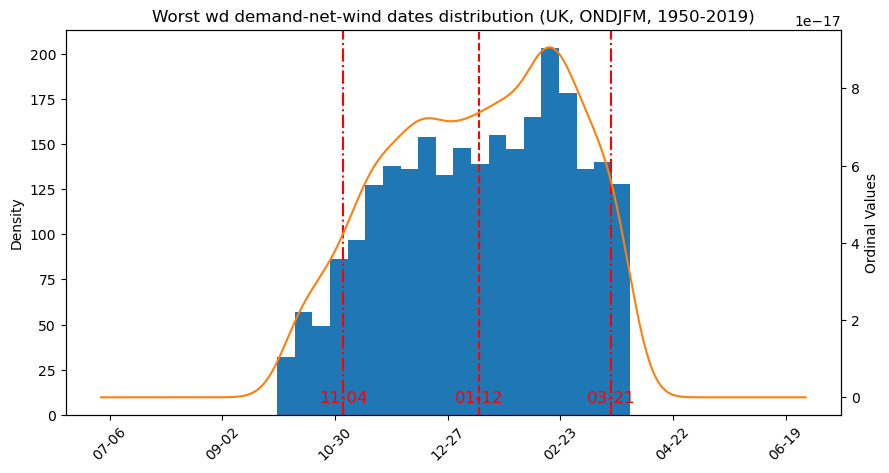

In [34]:
# set up the boxplot
fig, ax = plt.subplots(figsize=(10, 5))

df_severity["dates"].astype(np.int64).plot.hist(ax=ax, bins=20)
df_severity["dates"].astype(np.int64).plot.kde(ax=ax, secondary_y=True)

# calculate the median
median = df_severity["dates"].astype(np.int64).median()

# calculate the mean
mean = df_severity["dates"].astype(np.int64).mean()

# calculate the 05 and 95 percentiles
low_ci = np.percentile(df_severity["dates"].astype(np.int64), 8)
high_ci = np.percentile(df_severity["dates"].astype(np.int64), 95)

# plot the mean as a vertical red line
ax.axvline(mean, color="r", linestyle="--", label=f"Mean: {mean}")

# plot the 05 as a dotdash line
ax.axvline(low_ci, color="r", linestyle="-.", label=f"8%: {low_ci}")
ax.axvline(high_ci, color="r", linestyle="-.", label=f"95%: {high_ci}")

# pritn the mean and the date
print(f"mean: {mean}, date: {pd.to_datetime(int(mean)).date()}")
print(f"median: {median}, date: {pd.to_datetime(int(median)).date()}")
print(f"low_ci: {low_ci}, date: {pd.to_datetime(int(low_ci)).date()}")
print(f"high_ci: {high_ci}, date: {pd.to_datetime(int(high_ci)).date()}")

labels = ax.get_xticks().tolist()
# strip to only be MM-DD
labels = pd.to_datetime(labels)

# convert to MM-DD
labels = [date.strftime("%m-%d") for date in labels]
ax.set_xticklabels(labels, rotation=45)

# Convert ordinal values back to datetime.date for y-axis labels
# yticks = ax.get_yticks()
# yticks_dates = [pd.to_datetime(int(ytick)).date() for ytick in yticks]

# # Set y-axis labels
# ax.set_yticklabels(yticks_dates)

mean_date = pd.to_datetime(int(mean)).date().strftime("%m-%d")
low_ci_date = pd.to_datetime(int(low_ci)).date().strftime("%m-%d")
high_ci_date = pd.to_datetime(int(high_ci)).date().strftime("%m-%d")

# plot the mean date as MM-DD next to the mean line
ax.text(mean, 7, mean_date, ha="center", fontsize=12, color="red")

# plot the 05 date as MM-DD next to the 05 line
ax.text(low_ci, 7, low_ci_date, ha="center", fontsize=12, color="red")

# plot the 95 date as MM-DD next to the 95 line
ax.text(high_ci, 7, high_ci_date, ha="center", fontsize=12, color="red")

plt.xlabel('Dates')
plt.ylabel('Ordinal Values')
plt.title('Worst wd demand-net-wind dates distribution (UK, ONDJFM, 1950-2019)')
plt.show()

In [35]:
df_exceedance_days.head()

,severity,no_exceedance_days
1950,197.200824,52.0
1951,106.102625,31.0
1952,214.498306,61.0
1953,82.372201,41.0
1954,102.059898,35.0


In [36]:
df_full_daily_ONDJFM.head()

,solar_power,100m_wind_speed,10m_wind_speed,solar_irradiance,ofs_cfs,ons_cfs,t2m_no_detrend,t2m_2020_detrend,United_Kingdom_demand,United_Kingdom_wd_demand,wind_gen,demand_net_wind,wd_demand_net_wind
1950-01-01,0.017917,8.046321,5.313241,18.246765,0.375553,0.378995,5.568366,7.035546,38.408018,43.098834,11.175803,27.232215,31.923031
1950-01-02,0.009749,8.309860,5.536100,10.066186,0.755816,0.260311,7.458939,8.926063,40.257548,41.065818,15.022598,25.234949,26.043220
1950-01-03,0.006689,5.999976,3.996584,6.909895,0.383306,0.247291,6.999079,8.466145,41.153278,41.153278,9.332292,31.820987,31.820987
1950-01-04,0.014198,7.579509,4.991658,14.658528,0.503725,0.366872,7.507976,8.974984,40.990399,40.990399,12.886887,28.103513,28.103513
1950-01-05,0.009825,9.282607,6.286204,10.173406,0.768395,0.415419,6.869317,8.336267,41.490605,41.490605,17.514048,23.976557,23.976557


In [37]:
# make sure that the index is in datetime format
df_full_daily_ONDJFM.index = pd.to_datetime(df_full_daily_ONDJFM.index)

In [38]:
df_full_daily_ONDJFM.head()

,solar_power,100m_wind_speed,10m_wind_speed,solar_irradiance,ofs_cfs,ons_cfs,t2m_no_detrend,t2m_2020_detrend,United_Kingdom_demand,United_Kingdom_wd_demand,wind_gen,demand_net_wind,wd_demand_net_wind
1950-01-01,0.017917,8.046321,5.313241,18.246765,0.375553,0.378995,5.568366,7.035546,38.408018,43.098834,11.175803,27.232215,31.923031
1950-01-02,0.009749,8.309860,5.536100,10.066186,0.755816,0.260311,7.458939,8.926063,40.257548,41.065818,15.022598,25.234949,26.043220
1950-01-03,0.006689,5.999976,3.996584,6.909895,0.383306,0.247291,6.999079,8.466145,41.153278,41.153278,9.332292,31.820987,31.820987
1950-01-04,0.014198,7.579509,4.991658,14.658528,0.503725,0.366872,7.507976,8.974984,40.990399,40.990399,12.886887,28.103513,28.103513
1950-01-05,0.009825,9.282607,6.286204,10.173406,0.768395,0.415419,6.869317,8.336267,41.490605,41.490605,17.514048,23.976557,23.976557


In [39]:
# Calculate the seasonal mean temperature and wind speed
# to see whether these correlate with the severity index
df_ONDJFM = df_full_daily_ONDJFM[df_full_daily_ONDJFM.index.month.isin([10, 11, 12, 1, 2, 3])]

# shift the index back by 3 months and take the annual mean
df_ONDJFM_shifted = df_ONDJFM.shift(-3, freq='M').resample('A').mean()

In [40]:
# drop the first and last row
df_ONDJFM_shifted = df_ONDJFM_shifted.iloc[1:-1]

In [43]:
# set the index of df_ONDJFM_shifted to be the year
df_ONDJFM_shifted.index = df_ONDJFM_shifted.index.year

In [45]:
df_exceedance_days.tail()

,severity,no_exceedance_days
2015,70.134079,29.0
2016,66.740386,33.0
2017,48.709412,24.0
2018,65.467965,25.0
2019,46.683029,23.0


In [46]:
df_ONDJFM_shifted.tail()

,solar_power,100m_wind_speed,10m_wind_speed,solar_irradiance,ofs_cfs,ons_cfs,t2m_no_detrend,t2m_2020_detrend,United_Kingdom_demand,United_Kingdom_wd_demand,wind_gen,demand_net_wind,wd_demand_net_wind
2015,0.045989,8.546028,5.803546,65.247696,0.604229,0.381584,7.051015,7.134888,39.997589,41.452842,14.588643,25.408946,26.864199
2016,0.047428,7.717142,5.185671,80.963707,0.510453,0.312648,6.824999,6.887897,40.287380,41.750628,12.180066,28.107314,29.570563
2017,0.046698,8.437108,5.717490,90.249214,0.604882,0.372400,5.869819,5.911770,40.966321,42.429570,14.461741,26.504580,27.967829
2018,0.046976,8.259077,5.535166,90.075439,0.563557,0.363519,7.054070,7.075075,40.049438,41.512686,13.719924,26.329514,27.792762
2019,0.047315,8.718687,5.897901,100.707596,0.614796,0.402140,6.523098,6.523128,40.475453,41.930705,15.050145,25.425308,26.880560


In [47]:
from scipy.stats import pearsonr

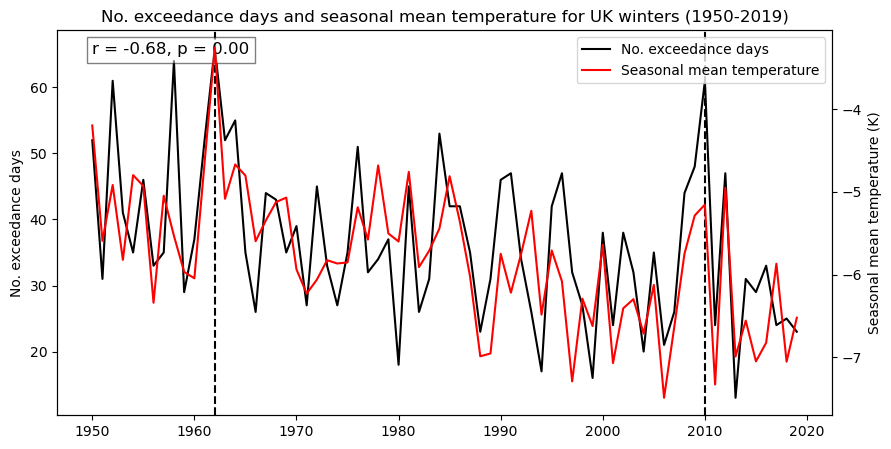

In [50]:
# plot the number of exceedance days and severity index using two y-axes
fig, ax1 = plt.subplots(figsize=(10, 5))

# plot the number of exceedance days
exc_days = ax1.plot(df_exceedance_days.index, df_exceedance_days["no_exceedance_days"], color="k", label="No. exceedance days")

# incldue a vertical line for 1963 and 2010
ax1.axvline(1962, color="k", linestyle="--")
ax1.axvline(2010, color="k", linestyle="--")

# set the ylabel
ax1.set_ylabel("No. exceedance days")

# duplicate the x-axis
ax2 = ax1.twinx()

# # plot the severity index
# sev = ax2.plot(df_exceedance_days.index, df_exceedance_days["severity"], color="r", label="Severity index")

# plot the seasonal mean temperature "t2m_no_detrend"
sev = ax2.plot(df_ONDJFM_shifted.index, -df_ONDJFM_shifted["t2m_no_detrend"], color="r", label="Seasonal mean temperature")

# set the ylabel
ax2.set_ylabel("Seasonal mean temperature (K)")

# set the title
ax1.set_title("No. exceedance days and seasonal mean temperature for UK winters (1950-2019)")

r, p = pearsonr(df_exceedance_days["no_exceedance_days"], df_ONDJFM_shifted["t2m_no_detrend"])

# include a textbox in the top left with the correlation coefficient
ax1.text(1950, 65, f"r = {r:.2f}, p = {p:.2f}", ha="left", fontsize=12, color="black", bbox=dict(facecolor='white', alpha=0.5))

# # include text on the plot for 1962
# ax1.text(1962 - 4, 12, "1962/63", ha="center", fontsize=12, color="black")
# ax1.text(2010 - 4, 12, "2010/11", ha="center", fontsize=12, color="black")

lns = exc_days + sev
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc="upper right")

# # set the ylims for ax1
# ax1.set_ylim(10, 70)

# # set the ylims for ax2
# ax2.set_ylim(0, 320)

# # include the legend in the top right
# ax1.legend(loc="upper right")

# # include the legend in the upper left
# ax2.legend(loc="upper left")

# set up now dd-mm-yyyy hh:mm:ss
now = pd.Timestamp.now().strftime("%Y-%m-%d_%H-%M-%S")

# set up the path to the plot
path = f"/home/users/benhutch/unseen_multi_year/plots/{now}_severity_index_no_exceedance_days_UK_winters_1950_2019.png"

# save the plot
plt.savefig(path, dpi=600, bbox_inches="tight")

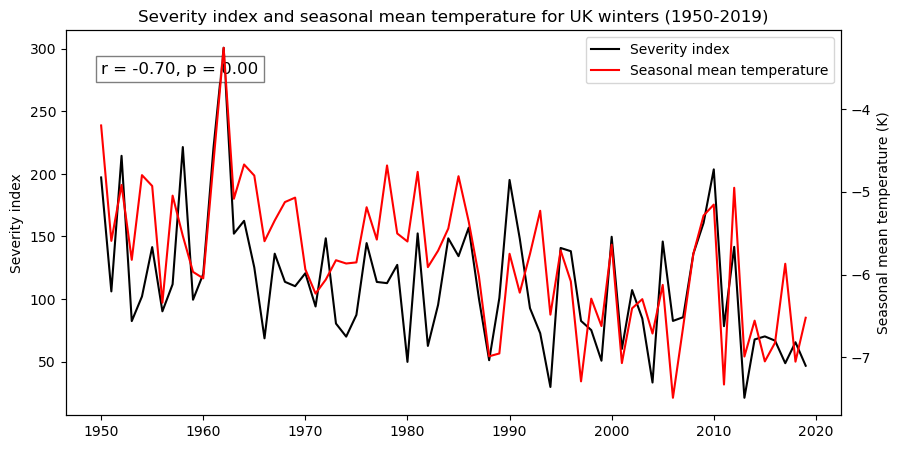

In [52]:
# plot the number of exceedance days and severity index using two y-axes
fig, ax1 = plt.subplots(figsize=(10, 5))

# plot the number of exceedance days
exc_days = ax1.plot(df_exceedance_days.index, df_exceedance_days["severity"], color="k", label="Severity index")

# # incldue a vertical line for 1963 and 2010
# ax1.axvline(1962, color="k", linestyle="--")
# ax1.axvline(2010, color="k", linestyle="--")

# set the ylabel
ax1.set_ylabel("Severity index")

# duplicate the x-axis
ax2 = ax1.twinx()

# # plot the severity index
# sev = ax2.plot(df_exceedance_days.index, df_exceedance_days["severity"], color="r", label="Severity index")

# plot the seasonal mean temperature "t2m_no_detrend"
sev = ax2.plot(df_ONDJFM_shifted.index, -df_ONDJFM_shifted["t2m_no_detrend"], color="r", label="Seasonal mean temperature")

# set the ylabel
ax2.set_ylabel("Seasonal mean temperature (K)")

# set the title
ax1.set_title("Severity index and seasonal mean temperature for UK winters (1950-2019)")

r, p = pearsonr(df_exceedance_days["severity"], df_ONDJFM_shifted["t2m_no_detrend"])

# include a textbox in the top left with the correlation coefficient
ax1.text(1950, 280, f"r = {r:.2f}, p = {p:.2f}", ha="left", fontsize=12, color="black", bbox=dict(facecolor='white', alpha=0.5))

# # include text on the plot for 1962
# ax1.text(1962 - 4, 12, "1962/63", ha="center", fontsize=12, color="black")
# ax1.text(2010 - 4, 12, "2010/11", ha="center", fontsize=12, color="black")

lns = exc_days + sev
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc="upper right")

# # set the ylims for ax1
# ax1.set_ylim(10, 70)

# # set the ylims for ax2
# ax2.set_ylim(0, 320)

# # include the legend in the top right
# ax1.legend(loc="upper right")

# # include the legend in the upper left
# ax2.legend(loc="upper left")

# set up now dd-mm-yyyy hh:mm:ss
now = pd.Timestamp.now().strftime("%Y-%m-%d_%H-%M-%S")

# set up the path to the plot
path = f"/home/users/benhutch/unseen_multi_year/plots/{now}_severity_index_no_exceedance_days_UK_winters_1950_2019.png"

# save the plot
plt.savefig(path, dpi=600, bbox_inches="tight")

In [53]:
df_ONDJFM_shifted.head()

,solar_power,100m_wind_speed,10m_wind_speed,solar_irradiance,ofs_cfs,ons_cfs,t2m_no_detrend,t2m_2020_detrend,United_Kingdom_demand,United_Kingdom_wd_demand,wind_gen,demand_net_wind,wd_demand_net_wind
1950,0.047499,7.646948,5.173771,83.073708,0.548256,0.310508,4.196776,5.643096,42.319801,43.783050,12.706080,29.613721,31.076970
1951,0.047739,8.181735,5.514787,90.237427,0.560338,0.349737,5.592817,7.018162,41.233875,42.693545,13.467533,27.766342,29.226011
1952,0.050879,7.622873,5.111364,100.821899,0.502315,0.315162,4.916879,6.321249,41.823209,43.286458,12.097345,29.725864,31.189112
1953,0.046912,7.780230,5.257252,95.875870,0.508089,0.317957,5.822387,7.205811,41.090066,42.553315,12.224111,28.865955,30.329204
1954,0.050365,8.245254,5.576068,91.555550,0.610629,0.363492,4.797606,6.160084,41.805261,43.268509,14.414106,27.391154,28.854403


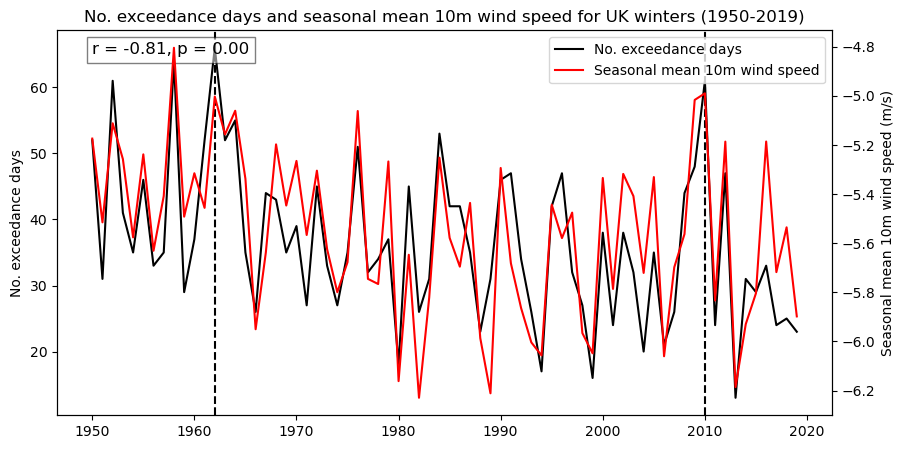

In [55]:
# plot the number of exceedance days and severity index using two y-axes
fig, ax1 = plt.subplots(figsize=(10, 5))

# plot the number of exceedance days
exc_days = ax1.plot(df_exceedance_days.index, df_exceedance_days["no_exceedance_days"], color="k", label="No. exceedance days")

# incldue a vertical line for 1963 and 2010
ax1.axvline(1962, color="k", linestyle="--")
ax1.axvline(2010, color="k", linestyle="--")

# set the ylabel
ax1.set_ylabel("No. exceedance days")

# duplicate the x-axis
ax2 = ax1.twinx()

# # plot the severity index
# sev = ax2.plot(df_exceedance_days.index, df_exceedance_days["severity"], color="r", label="Severity index")

# plot the seasonal mean temperature "t2m_no_detrend"
sev = ax2.plot(df_ONDJFM_shifted.index, -df_ONDJFM_shifted["10m_wind_speed"], color="r", label="Seasonal mean 10m wind speed")

# set the ylabel
ax2.set_ylabel("Seasonal mean 10m wind speed (m/s)")

# set the title
ax1.set_title("No. exceedance days and seasonal mean 10m wind speed for UK winters (1950-2019)")

r, p = pearsonr(df_exceedance_days["no_exceedance_days"], df_ONDJFM_shifted["10m_wind_speed"])

# include a textbox in the top left with the correlation coefficient
ax1.text(1950, 65, f"r = {r:.2f}, p = {p:.2f}", ha="left", fontsize=12, color="black", bbox=dict(facecolor='white', alpha=0.5))

# # include text on the plot for 1962
# ax1.text(1962 - 4, 12, "1962/63", ha="center", fontsize=12, color="black")
# ax1.text(2010 - 4, 12, "2010/11", ha="center", fontsize=12, color="black")

lns = exc_days + sev
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc="upper right")

# # set the ylims for ax1
# ax1.set_ylim(10, 70)

# # set the ylims for ax2
# ax2.set_ylim(0, 320)

# # include the legend in the top right
# ax1.legend(loc="upper right")

# # include the legend in the upper left
# ax2.legend(loc="upper left")

# set up now dd-mm-yyyy hh:mm:ss
now = pd.Timestamp.now().strftime("%Y-%m-%d_%H-%M-%S")

# set up the path to the plot
path = f"/home/users/benhutch/unseen_multi_year/plots/{now}_severity_index_no_exceedance_days_UK_winters_1950_2019.png"

# save the plot
plt.savefig(path, dpi=600, bbox_inches="tight")

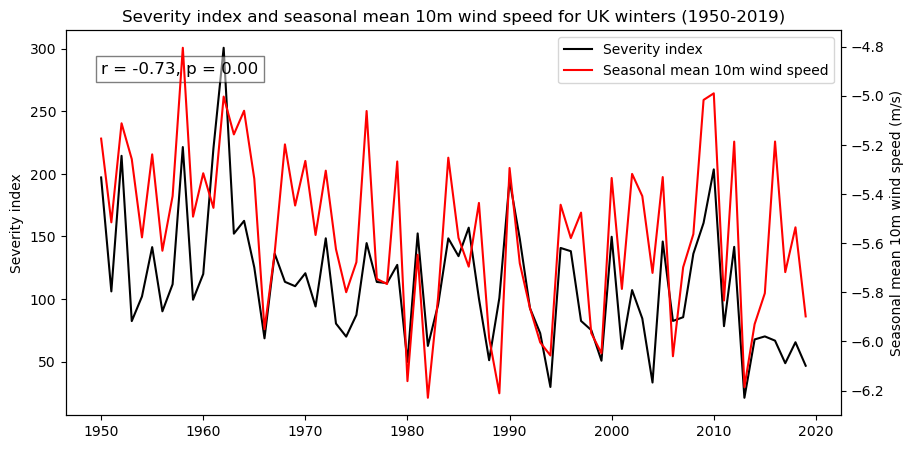

In [57]:
# plot the number of exceedance days and severity index using two y-axes
fig, ax1 = plt.subplots(figsize=(10, 5))

# plot the number of exceedance days
exc_days = ax1.plot(df_exceedance_days.index, df_exceedance_days["severity"], color="k", label="Severity index")
# # incldue a vertical line for 1963 and 2010
# ax1.axvline(1962, color="k", linestyle="--")
# ax1.axvline(2010, color="k", linestyle="--")

# set the ylabel
ax1.set_ylabel("Severity index")

# duplicate the x-axis
ax2 = ax1.twinx()

# # plot the severity index
# sev = ax2.plot(df_exceedance_days.index, df_exceedance_days["severity"], color="r", label="Severity index")

# plot the seasonal mean temperature "t2m_no_detrend"
sev = ax2.plot(df_ONDJFM_shifted.index, -df_ONDJFM_shifted["10m_wind_speed"], color="r", label="Seasonal mean 10m wind speed")

# set the ylabel
ax2.set_ylabel("Seasonal mean 10m wind speed (m/s)")

# set the title
ax1.set_title("Severity index and seasonal mean 10m wind speed for UK winters (1950-2019)")

r, p = pearsonr(df_exceedance_days["severity"], df_ONDJFM_shifted["10m_wind_speed"])

# include a textbox in the top left with the correlation coefficient
ax1.text(1950, 280, f"r = {r:.2f}, p = {p:.2f}", ha="left", fontsize=12, color="black", bbox=dict(facecolor='white', alpha=0.5))

# # include text on the plot for 1962
# ax1.text(1962 - 4, 12, "1962/63", ha="center", fontsize=12, color="black")
# ax1.text(2010 - 4, 12, "2010/11", ha="center", fontsize=12, color="black")

lns = exc_days + sev
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc="upper right")

# # set the ylims for ax1
# ax1.set_ylim(10, 70)

# # set the ylims for ax2
# ax2.set_ylim(0, 320)

# # include the legend in the top right
# ax1.legend(loc="upper right")

# # include the legend in the upper left
# ax2.legend(loc="upper left")

# set up now dd-mm-yyyy hh:mm:ss
now = pd.Timestamp.now().strftime("%Y-%m-%d_%H-%M-%S")

# set up the path to the plot
path = f"/home/users/benhutch/unseen_multi_year/plots/{now}_severity_index_no_exceedance_days_UK_winters_1950_2019.png"

# save the plot
plt.savefig(path, dpi=600, bbox_inches="tight")

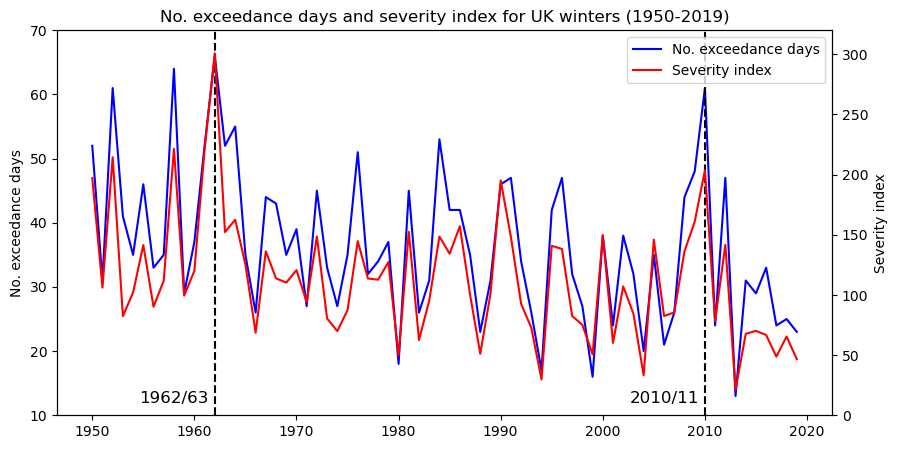

In [44]:
# plot the number of exceedance days and severity index using two y-axes
fig, ax1 = plt.subplots(figsize=(10, 5))

# plot the number of exceedance days
exc_days = ax1.plot(df_exceedance_days.index, df_exceedance_days["no_exceedance_days"], color="b", label="No. exceedance days")

# incldue a vertical line for 1963 and 2010
ax1.axvline(1962, color="k", linestyle="--")
ax1.axvline(2010, color="k", linestyle="--")

# set the ylabel
ax1.set_ylabel("No. exceedance days")

# duplicate the x-axis
ax2 = ax1.twinx()

# plot the severity index
sev = ax2.plot(df_exceedance_days.index, df_exceedance_days["severity"], color="r", label="Severity index")

# set the ylabel
ax2.set_ylabel("Severity index")

# set the title
ax1.set_title("No. exceedance days and severity index for UK winters (1950-2019)")

# include text on the plot for 1962
ax1.text(1962 - 4, 12, "1962/63", ha="center", fontsize=12, color="black")
ax1.text(2010 - 4, 12, "2010/11", ha="center", fontsize=12, color="black")

lns = exc_days + sev
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc="upper right")

# set the ylims for ax1
ax1.set_ylim(10, 70)

# set the ylims for ax2
ax2.set_ylim(0, 320)

# # include the legend in the top right
# ax1.legend(loc="upper right")

# # include the legend in the upper left
# ax2.legend(loc="upper left")

# set up now dd-mm-yyyy hh:mm:ss
now = pd.Timestamp.now().strftime("%Y-%m-%d_%H-%M-%S")

# set up the path to the plot
path = f"/home/users/benhutch/unseen_multi_year/plots/{now}_severity_index_no_exceedance_days_UK_winters_1950_2019.png"

# save the plot
plt.savefig(path, dpi=600, bbox_inches="tight")

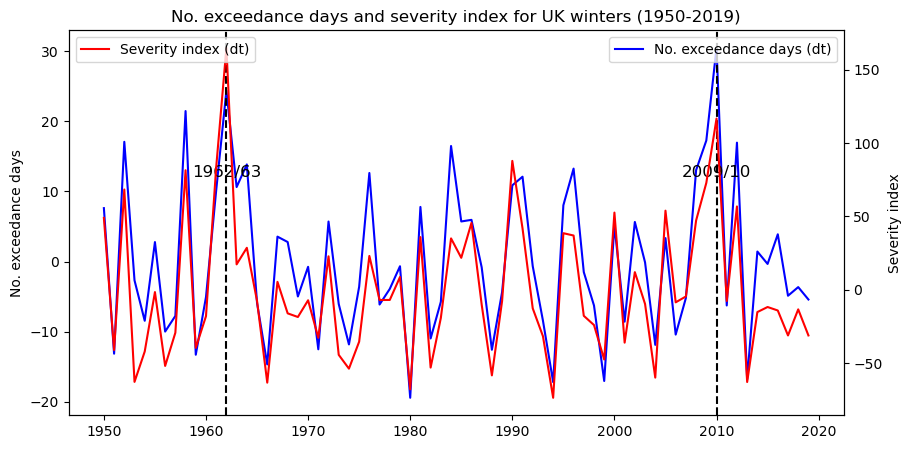

In [37]:
# do the same but detrend
from scipy import signal

# plot the number of exceedance days and severity index using two y-axes
fig, ax1 = plt.subplots(figsize=(10, 5))

# detrend the no. exceedance days
no_exceedance_days_detrend = signal.detrend(df_exceedance_days["no_exceedance_days"])
severity_detrend = signal.detrend(df_exceedance_days["severity"])

# plot the number of exceedance days
ax1.plot(df_exceedance_days.index, no_exceedance_days_detrend, color="b", label="No. exceedance days (dt)")

# incldue a vertical line for 1963 and 2010
ax1.axvline(1962, color="k", linestyle="--")
ax1.axvline(2010, color="k", linestyle="--")

# set the ylabel
ax1.set_ylabel("No. exceedance days")

# duplicate the x-axis
ax2 = ax1.twinx()

# plot the severity index
ax2.plot(df_exceedance_days.index, severity_detrend, color="r", label="Severity index (dt)")

# set the ylabel
ax2.set_ylabel("Severity index")

# set the title
ax1.set_title("No. exceedance days and severity index for UK winters (1950-2019)")

# include text on the plot for 1962
ax1.text(1962, 12, "1962/63", ha="center", fontsize=12, color="black")
ax1.text(2010, 12, "2009/10", ha="center", fontsize=12, color="black")

# include the legend in the top right
ax1.legend(loc="upper right")

# include the legend in the upper left
ax2.legend(loc="upper left")

In [38]:
# set up the path to the temperature data
path = "/gws/nopw/j04/canari/users/benhutch/ERA5"

# list the files in this directory
files = os.listdir(path)

# print the files
print(files)